# ARI2204 – Reinforcement Learning

### Isaac Muscat - 0265203L
### Matthias Bartolo - 0436103L
### Jerome Agius - 0353803L

# Packages

In [1]:
#Importing and installing necessary packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

# Game Components

In [2]:
# Defining the point cost of each card value
PointsLookup={ "2":2, "3": 3, "4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"10":10,"Q":10,"J":10,"K":10, "A":11}

In [3]:
# Defining the card components that compose a deck 
cardsValue= {"A", "2","3", "4", "5", "6", "7", "8", "9", "10","J","Q","K"}
cardsSuit={"Diamonds", "Spades","Clubs","Hearts"}

### Method which calculates the total points given a number of cards

In [4]:
def GetTotalPoints(player):
    totalPoints=0
    
    # Looping through the cards in the player hand
    for cards in player.hand:
        # Summing up the total points 
        totalPoints+=PointsLookup[cards[1]]
        # If the player has more than 1 ace all other aces are assigned the value of 1 according to black jack rules
        if cards[1] == "A" and player.hasAce:
            totalPoints-=10 
        # If the player has only 1 ace the hasAce flag is set to true to activate the above if statement  
        elif cards[1] == "A" and not(player.hasAce):
            player.hasAce=True
    
    # If the player has an ace and more than 21 points the value of said ace 
    # is set to 1 so as to not set him over the point limit and hasAce flag is set to false
    if(player.hasAce and totalPoints>21):
        totalPoints-=10
        player.hasAce=False
    return totalPoints


### Method denoting a Hit Action

In [5]:
def Hit(player,cardDeck):
    # Removing the top card from the deck 
    card=cardDeck.pop(0)
    # Adding said card to the player hand 
    player.hand.append(card)

### Method denoting a Stand Action

In [6]:
def Stand(player):
    # Setting the stand flag to denote that the player has stopped playing
    player.stand=True

### Method used to check if the Player / Dealer has won 

In [7]:
def CheckWin(player,dealer):
    # Checking if the player has equal points to the dealer and the dealer has stood resulting in a draw
    if(dealer.stand and player.totalPoints==dealer.totalPoints):
        return 0
    # Checking if the player has exactly 21 points resulting in a win 
    elif(player.totalPoints==21):
        return  1
    # Checking if the dealer has exactly 21 points resulting in a loss 
    elif(dealer.totalPoints==21):
        return -1
    # Checking if the player has more than 21 points resulting in a loss 
    elif(player.totalPoints>21):
        return -1
    # Checking if the dealer has more than 21 points resulting in a win 
    elif(dealer.totalPoints>21):
        return  1
    # Checking if the dealer has stood and has less points than the player resulting in a win
    elif(dealer.stand and player.totalPoints>dealer.totalPoints):
        return  1
    # Checking if the dealer has stood and has more points than the player resulting in loss
    elif(dealer.stand and player.totalPoints<dealer.totalPoints):
        return  -1
    # Returning None if game is still on going 
    return None

### Class denoting the Player Object

In [8]:
class Player:
    # Method to initialise the player object, each player starts of with:
    # an empty hand, 0 points and both flags set to false 
    def __init__(self):
        self.hand=list()
        self.totalPoints=0
        self.stand=False
        self.hasAce=False

### Method used to initialise the starting state of the game 

In [9]:
def InitiateGame():
    # Initialising an empty deck
    cardDeck=list()
    # Initialising two players
    player=Player()
    dealer=Player()
    
    # Assigning all the cards to the deck
    for suit in cardsSuit:
        for value in cardsValue:
            cardDeck.append((suit,value))
    # Shuffling the cards in the deck
    random.shuffle(cardDeck)
    
    # Assigning two cards to the player and dealer
    Hit(player,cardDeck)
    Hit(player,cardDeck)
    Hit(dealer,cardDeck)
    Hit(dealer,cardDeck)
    # Assigning the appropriate points to the player and the dealer 
    player.totalPoints=GetTotalPoints(player)
    dealer.totalPoints=GetTotalPoints(dealer)
    return player,dealer,cardDeck

### Method to initialise the QTable (Data structure containing all possible states and relevant information)

In [10]:
def InitialiseQTable():
    Qtable=dict()
    
    # Looping if the player has between 12 and 21 points
    for playerPoints in range(12,22):
        # Looping if the dealer has between 2 and 11 points (meaning they only have 1 card)
        for dealerCard in range(2,12):
            # Looping twice, once for each possible state given that the player is in possesion of an ace
            for AceFlag in [True,False]:
                # Constructing the state which consists of the player and dealer points 
                # as well as whether an ace is in the player hand
                state=str(playerPoints)+","+str(dealerCard)+","+str(AceFlag)
                Qtable[state]={}
                # Assigning the Q-value and times visited to each state, both initialised to 0
                for action in ["Hit","Stand"]:
                    Qtable[state][action]={"Values":0,"Count":0}
    return Qtable

### Method used to retrieve the action according to the max Q-value for the specified state

In [11]:
def ArgMax(Qtable, state):
    # Checking if hit has a greater value than stand and returning the appropriate action
    if(Qtable[state]["Hit"]["Values"]>=Qtable[state]["Stand"]["Values"]):
        return "Hit"
    else:
        return "Stand"

# Monte Carlo

### Method defining the PlayerPolicy (Technique determining which actions the player will choose)

1. player - Holds the player object
2. dealer - Holds the dealer object
3. cardDeck - Holds the card deck object 
4. stepNumber - Value denoting which step we are currently in
5. epsilon - Value denoting the exploration probability
6. Qtable - Data structure holding the possible states along with their value and number of times visited
7. exploreFlag - Flag denoting if random exploration should occur as the initial step

In [12]:
def PlayerPolicy(player,dealer,cardDeck,stepNumber,epsilon,Qtable,exploreFlag):

    action=None
    # Constructing the current state
    state=str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce)
    
    # Checking if the player has exactly 21 points, if so the player stands as further playing would lead to a less
    if player.totalPoints==21:
        Stand(player)
        action="Stand"
    # Checking if the player has between 12 and 20 points, if so executing an action and transferring to a successor state 
    elif player.totalPoints>11 and player.totalPoints<21:
        # Checking if it's the first step and the explore flag is set to true, if so the player 
        # will randomly choose to hit or stand with equal probability 
        if(stepNumber==1 and exploreFlag == True):
            if(random.randint(0,1)==1):
                action="Hit"
                Hit(player,cardDeck)
                # Updating the player points accordingly 
                player.totalPoints=GetTotalPoints(player)
            else:
                action="Stand"
                Stand(player)
        # If the above doesn't hold, the player will choose to either hit/stand 
        # with equal probability (Exploration) or choose the best possible action (Exploitation) in accordance with epsilon 
        else:
            if(random.random()<epsilon): # Probability of epsilon
                if(random.randint(0,1)==1):
                    action="Hit"
                    Hit(player,cardDeck)
                    # Updating the player points accordingly 
                    player.totalPoints=GetTotalPoints(player)
                else:
                    action="Stand"
                    Stand(player)
            else:# Probability of 1-epsilon
                bestAction=ArgMax(Qtable, state)
                if(bestAction=="Hit"):
                    action="Hit"
                    Hit(player,cardDeck)
                    # Updating the player points accordingly 
                    player.totalPoints=GetTotalPoints(player)
                else:
                    action="Stand"
                    Stand(player)
    # If the above doesn't hold, the player will be forced to hit as this action has no 
    # downside given that the player has less than 12 points
    else:
        Hit(player,cardDeck)
        player.totalPoints=GetTotalPoints(player)
        action="Hit"
        # This action maps to no state in the Q-table given that the player has less than 12 points 
        state=None
    
    # Returning the old state and action carried out 
    return [state,action]

### Method defining the rules of a Black Jack Round  
1. configBit - Value denoting the chosen configuration type
2. player - Holds the player object
3. dealer - Holds the dealer object
4. cardDeck - Holds the card deck object 
5. episode - Denotes the current episode (An episode consists of a full sequnce of actions leading to a terminal state)
6. Qtable - Data structure holding the possible states along with their value and number of times visited

In [13]:
def BlackJackRoundMonteCarlo(configBit,player,dealer,cardDeck,episode,Qtable):  
    # Checking if the player has won/lost
    checkWin=CheckWin(player,dealer)
    # Initialising the stepNumber 
    stepNumber=1
    # Initialising the stateAction list
    stateAction=list()
    # Looping until a winner is determined
    while True:
        
        # Utilising the intended policy according to the configBit
        if(configBit==1):
            # Policy with exploration turned on with epsilon being 1/episode
            resultantStateAction=PlayerPolicy(player,dealer,cardDeck,stepNumber,1/episode,Qtable, True) 
        elif(configBit==2):
            # Policy with exploration turned off with epsilon being 1/episode
            resultantStateAction=PlayerPolicy(player,dealer,cardDeck,stepNumber,1/episode,Qtable, False)
        elif(configBit==3):
            # Policy with exploration turned off with epsilon being e^-episode/1000 
            resultantStateAction=PlayerPolicy(player,dealer,cardDeck,stepNumber,math.e**(-episode/1000),Qtable, False) 
        elif(configBit==4):
            # Policy with exploration turned off with epsilon being e^-episode/10000
            resultantStateAction=PlayerPolicy(player,dealer,cardDeck,stepNumber,math.e**(-episode/10000),Qtable, False) 
        
        # Appending the resultant action in accordance with the policy
        stateAction.append(resultantStateAction)
        
        # Checking if the player has stood and has less than 22 points, if this is the case 
        # the dealer will proceed to hit until they have more than 17 points
        if player.stand is True and player.totalPoints<=21:
            while dealer.totalPoints<17:
                Hit(dealer,cardDeck)
                # Updating the dealer points accordingly 
                dealer.totalPoints=GetTotalPoints(dealer)
            Stand(dealer)
        
        checkWin=CheckWin(player,dealer)
        
        # If a winner is chosen, exit from the loop
        if(checkWin is not None):
            break
        # Incrementing the stepNumber
        stepNumber+=1
    
    # Returning the winning condition and resultant stateAction
    return checkWin,stateAction

### Method used to outline the step by step happenings throughout the game

In [14]:
def GameMonteCarlo(configBit, discountFactor, episodes=100000):
    episodesDict = {"wins": [], "draws": [], "losses": [], "episodes": [], "stateAction": {}, "qEstimatedValue": {}}
    qTableLookupList=list()
    Qtable=InitialiseQTable()
    playerWins,dealerWins,draws,reward=0,0,0,0
    rewardEpisode=0
    
    # Looping through all the episodes
    for episode in range(1,episodes+1):
        player,dealer,cardDeck=InitiateGame()
        
        # Simulating a single black jack round
        checkWin,stateActionList=BlackJackRoundMonteCarlo(configBit,player, dealer,cardDeck,episode,Qtable)

        # Adding the points accordingly based on the results of the game
        if(checkWin==1):
            playerWins+=1
            reward+=1
            rewardEpisode=1
        elif(checkWin==-1):
            dealerWins+=1
            reward-=1
            rewardEpisode=-1
        else:
            draws+=1
        futureReward=0
        
        # Looping through all the state actions in a single episode and updating "count" and "values" of the QTable accordingly
        for stateaction in reversed(stateActionList):
            if(stateaction[0] is not None):
                futureReward+=rewardEpisode
                Qtable[stateaction[0]][stateaction[1]]["Count"]+=1
                Qtable[stateaction[0]][stateaction[1]]["Values"]= Qtable[stateaction[0]][stateaction[1]]["Values"]*discountFactor + float(1/Qtable[stateaction[0]][stateaction[1]]["Count"]*(futureReward-Qtable[stateaction[0]][stateaction[1]]["Values"]))
               
            key=str(stateaction[0])+","+str(stateaction[1])
            
            # Incrementing the visited counter for each state action pair
            if(key not in episodesDict["stateAction"].keys() and stateaction[0] is not None):
                episodesDict["stateAction"][key] = 1
                qTableLookupList.append((stateaction[0],stateaction[1]))
            elif(stateaction[0] is not None):
                episodesDict["stateAction"][key] += 1

        # Storing the relevant information in 1000 episode intervals
        if(episode%1000==0):
            # Printing the requested results
            print("Episode: ",episode," Player Wins:",playerWins," Dealer Wins: ",dealerWins," Draws: ",draws, " Reward: ",reward)
            episodesDict["wins"].append(playerWins)
            episodesDict["draws"].append(draws)
            episodesDict["losses"].append(dealerWins)
            episodesDict["episodes"].append(episode)
            
            # Resetting counts to zero
            playerWins,dealerWins,draws,reward=0,0,0,0
    
    # Updating the qEstimatedValue for the respective state action pair and returning the corresponding dictionary 
    for qKey in qTableLookupList:
        if(qKey[0] not in episodesDict["qEstimatedValue"].keys()):
            episodesDict["qEstimatedValue"][qKey[0]]={qKey[1]:Qtable[qKey[0]][qKey[1]]["Values"]}
        else:
            episodesDict["qEstimatedValue"][qKey[0]][qKey[1]]=Qtable[qKey[0]][qKey[1]]["Values"]
        
    # Sorting the state action pairs by descending order
    episodesDict["stateAction"] = {k: v for k, v in sorted(episodesDict["stateAction"].items(), key=lambda item: item[1])}
    return episodesDict

# Sarsa and SarsaMax

### Method to choose the best action according to the Epsilon Greedy Policy

In [15]:
def TakeEpsilonGreedyPolicy(state, Qtable, epsilon):
    
    # Constructing the current state
    stateParams=state.split(",")
    
    # Checking if the player has exactly 21 points, if so the player stands as further playing would lead to a less
    if int(stateParams[0])==21:
        action="Stand"
    
    # Checking if the player has between 12 and 20 points, if so executing an action and transferring to a successor state 
    elif int(stateParams[0])>11 and int(stateParams[0])<21:
        # Choosing to either hit/stand with equal probability (Exploration) or 
        # choosing the best possible action (Exploitation) in accordance with epsilon 
        if(random.random()<epsilon): # Probability of epsilon
            if(random.randint(0,1)==1):
                action="Hit"
            else:
                action="Stand"
        else: # Probability of 1-epsilon
            # Choosing the best action via the ArgMax function
            bestAction=ArgMax(Qtable, state)
            if(bestAction=="Hit"):
                action="Hit"
            else:
                action="Stand"
    else:
        action="Hit"
        
    return action

### Method to choose the best action according to the Greedy Policy

In [16]:
def TakeGreedyPolicy(state, Qtable):
    
    # Constructing the current state
    stateParams=state.split(",")
    
    # Checking if the player has exactly 21 points, if so the player stands as further playing would lead to a less
    if int(stateParams[0])==21:
        action="Stand"
        
    # Checking if the player has between 12 and 20 points, if so executing an action and transferring to a successor state 
    elif int(stateParams[0])>11 and int(stateParams[0])<21:
        
        # Choosing the best action via the ArgMax function
        bestAction=ArgMax(Qtable, state)
        if(bestAction=="Hit"):
            action="Hit"
        else:
            action="Stand"
    else:
        action="Hit"
    
    return action

### Method defining the rules of a Black Jack Round 

1. configBit - Value denoting the chosen configuration type
2. sarsaConfigBit - Value denoting the chosen SARSA or SARSA Max
3. player - Holds the player object
4. dealer - Holds the dealer object
5. cardDeck - Holds the card deck object 
6. episode - Denotes the current episode (An episode consists of a full sequnce of actions leading to a terminal state)
7. Qtable - Data structure holding the possible states along with their value and number of times visited
8. maxSteps - Steps in an episode (Set to a large value)
9. discountFactor - Value used to denote the importance of future rewards

In [17]:
def BlackJackRoundSarsa(configBit,sarsaConfigBit,player,dealer,cardDeck,episode,Qtable,maxSteps,discountFactor):  
    epsilon=0
    # Checking if the player has won/lost
    checkWin=CheckWin(player,dealer)
    stateAction=list()
    
    # Utilising the intended policy according to the configBit
    if(configBit==1):
        # Setting epsilon to 0.1
        epsilon=0.1
    elif(configBit==2):
        # Setting epsilon to 1 divided by the episode count
        epsilon=1/episode
    elif(configBit==3):
        # Setting epsilon to e ^ -episode count / 1000 
        epsilon=math.e**(-episode/1000) 
    elif(configBit==4):
        # Setting epsilon to e ^ -episode count / 10000 
        epsilon=math.e**(-episode/10000)
        
    stepNumber=1  
    
    # Constructing the current state
    state=str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce) 
    
    # Getting the next action based on epsilon greedy policy
    action=TakeEpsilonGreedyPolicy(state, Qtable, epsilon)
    
    # Loop to maxSteps
    while stepNumber<maxSteps:    
        
        # Playing the appropriate action
        if(action=="Hit"):
            Hit(player,cardDeck)
            player.totalPoints=GetTotalPoints(player)
        else:
            Stand(player)
        
        # Checking if the player has stood and has less than 22 points, if this is the case 
        # the dealer will proceed to hit until they have more than 17 points
        if player.stand is True and player.totalPoints<=21:
            while dealer.totalPoints<17:
                Hit(dealer,cardDeck)
                # Updating the dealer points accordingly 
                dealer.totalPoints=GetTotalPoints(dealer)
            Stand(dealer)
        
        # Checking if the player has won/lost
        checkWin=CheckWin(player,dealer)
        reward=0
        
        # Updating the reward appropriately
        if(checkWin==1):
            reward=1
        elif(checkWin==-1):
            reward=-1
        elif(checkWin==0):
            reward=0          
        
        # Constructing the new current state
        newstate= str(player.totalPoints)+","+str(PointsLookup[dealer.hand[0][1]])+","+str(player.hasAce) 
        
        # Getting the next action based on epsilon greedy policy
        newaction=TakeEpsilonGreedyPolicy(newstate, Qtable, epsilon)
        
        # Adding the state action pair, updating the count of the QTable
        # and calculating alpha if the state is present in it
        if(state in Qtable.keys()):
            stateAction.append([state,action])
            Qtable[state][action]["Count"]+=1
            alpha=float(1/(Qtable[state][action]["Count"]+1))
    
        # Updating the corresponding QTable according to the sarsaConfigBit for Non-Terminal States
        # 1 is SARSA
        # 2 is SARSAMAX
        if(checkWin is None and state in Qtable.keys() and newstate in Qtable.keys()):
            if(sarsaConfigBit==1):
                Qtable[state][action]["Values"]+=float(alpha*(reward+discountFactor*Qtable[newstate][newaction]["Values"]-Qtable[state][action]["Values"]))
            else:
                Qtable[state][action]["Values"]+=float(alpha*(reward+discountFactor*Qtable[newstate][TakeGreedyPolicy(newstate, Qtable)]["Values"] -Qtable[state][action]["Values"]))
        # Updating for Terminal States
        elif(state in Qtable.keys()): 
            Qtable[state][action]["Values"]+=float(alpha*(reward-Qtable[state][action]["Values"]))

        action=newaction
        state=newstate
        stepNumber+=1
        # Checking if a winning condition has occurred
        if(checkWin is not None):
            break
        
    return checkWin,stateAction

### Method used to outline the step by step happenings throughout the game

In [18]:
def GameSarsa(configBit,sarsaConfigBit,episodes, maxSteps,  discountFactor):
    episodesDict = {"wins": [], "draws": [], "losses": [], "episodes": [], "stateAction": {}, "qEstimatedValue": {}}
    qTableLookupList=list()
    Qtable=InitialiseQTable()
    playerWins,dealerWins,draws,reward=0,0,0,0
    
    # Looping through all the episodes
    for episode in range(1,episodes+1):
        player,dealer,cardDeck=InitiateGame()
        
        # Simulating a single black jack round
        checkWin,stateActionList=BlackJackRoundSarsa(configBit,sarsaConfigBit,player, dealer,cardDeck,episode,Qtable,maxSteps,discountFactor)

        # Adding the points accordingly based on the results of the game
        if(checkWin==1):
            playerWins+=1
            reward+=1
        elif(checkWin==-1):
            dealerWins+=1
            reward-=1
        else:
            draws+=1
        
        # Looping through all the state actions in a single episode and updating "count" and "values" of the QTable accordingly
        for stateaction in stateActionList:
            key=str(stateaction[0])+","+str(stateaction[1])
            if(key not in episodesDict["stateAction"].keys() and stateaction[0] is not None):
                episodesDict["stateAction"][key]=1
                qTableLookupList.append((stateaction[0],stateaction[1]))
            elif(stateaction[0] is not None):
                episodesDict["stateAction"][key]+=1
        
        # Storing the relevant information in 1000 episode intervals
        if(episode%1000==0):
            
            # Printing the requested results
            print("Episode: ",episode," Player Wins:",playerWins," Dealer Wins: ",dealerWins," Draws: ",draws, " Reward: ",reward)
            episodesDict["wins"].append(playerWins)
            episodesDict["draws"].append(draws)
            episodesDict["losses"].append(dealerWins)
            episodesDict["episodes"].append(episode)
            
            # Resetting counts to zero
            playerWins,dealerWins,draws,reward=0,0,0,0

    # Updating the qEstimatedValue for the respective state action pair and returning the corresponding dictionary 
    for q in qTableLookupList:
        if(q[0] not in episodesDict["qEstimatedValue"].keys()):
            episodesDict["qEstimatedValue"][q[0]]={q[1]:Qtable[q[0]][q[1]]["Values"]}
        else:
            episodesDict["qEstimatedValue"][q[0]][q[1]]=Qtable[q[0]][q[1]]["Values"]

    # Sorting the state action pairs by descending order
    episodesDict["stateAction"] = {k: v for k, v in sorted(episodesDict["stateAction"].items(), key=lambda item: item[1])}
    return episodesDict

# Evaluation

### Method used to create a table denoting which actions were chosen in accordance with the player and dealer points

In [19]:
def CreateStrategyTable(qEstimatedValue):
    cols=["2","3","4","5","6","7","8","9","10","A"]
    # Creating the empty table
    emptyboard=np.zeros((9, 10) , dtype=str)
    # Table denoting which actions were chosen in accordance with the player and dealer points,
    # given that the player had an ace
    aceStrategyTable=pd.DataFrame(data=emptyboard,columns=cols)
    # Starting the indices at 12 since all otehr point values are irrelevant 
    aceStrategyTable.index+=12
    
    # Table denoting which actions were chosen in accordance with the player and dealer points,
    # given that the player didn't have an ace
    noAceStrategyTable=pd.DataFrame(data=emptyboard,columns=cols)
    # Starting the indices at 12 since all other point values are irrelevant 
    noAceStrategyTable.index+=12

    for currentState in qEstimatedValue:
        state=currentState.split(",")
        playerTotalPoints=int(state[0])-12
        dealerCard=int(state[1])-2
        
        # Assigning the appropriate action accordingly
        # Checking if the player has less than 21 points and according to whether
        # they have an ace or not the appropriate action is assigned to the respective table based on the Q value 
        if(state[2]=="False" and int(state[0])<21):
            if("Hit" not in qEstimatedValue[currentState].keys()):
                aceStrategyTable.values[playerTotalPoints,dealerCard]="S"
            elif("Stand" not in qEstimatedValue[currentState].keys()):
                aceStrategyTable.values[playerTotalPoints,dealerCard]="H"
            elif(qEstimatedValue[currentState]["Hit"]>qEstimatedValue[currentState]["Stand"]):
                aceStrategyTable.values[playerTotalPoints,dealerCard]="H"
            else:
                aceStrategyTable.values[playerTotalPoints,dealerCard]="S"
        elif(state[2]=="True"and int(state[0])<21):
            if("Hit" not in qEstimatedValue[currentState].keys()):
                noAceStrategyTable.values[playerTotalPoints,dealerCard]="S"
            elif("Stand" not in qEstimatedValue[currentState].keys()):
                noAceStrategyTable.values[playerTotalPoints,dealerCard]="H"
            elif(qEstimatedValue[currentState]["Hit"]>qEstimatedValue[currentState]["Stand"]):
                noAceStrategyTable.values[playerTotalPoints,dealerCard]="H"
            else:
                noAceStrategyTable.values[playerTotalPoints,dealerCard]="S"
    
    # Transposing the table to represent the data correctly
    noAceStrategyTable = noAceStrategyTable.iloc[::-1]
    aceStrategyTable = aceStrategyTable.iloc[::-1]
    
    # Displaying the tables
    print("\033[1m\nBlackJack Strategy Table when player is using an Ace as 1 \033[0m")
    display(noAceStrategyTable)
    print("\033[1m\nBlackJack Strategy Table when player is using an Ace as 11\033[0m")
    display(aceStrategyTable)

### Method used to display a line graph to the user in accordance with the passed data

In [20]:
def DrawLineGraph(winsArray,drawsArray,lossArray,episode,title):
    # Plotting the points with labels
    plt.plot(episode, winsArray, label = "Wins",color="green")
    plt.plot(episode, drawsArray, label = "Draws",color="orange")
    plt.plot(episode, lossArray, label = "Losses",color="red")

    # Naming the x-axis
    plt.xlabel("Episodes")
    # Naming the y-axis
    plt.ylabel("Wins/Draws/Losses")

    # Giving a title to the graph
    plt.title("Wins/Draws/Losses vs Episodes "+title)
    # Displaying legend
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    # Displaying plot
    plt.show()

### Method used to display a bar graph to the user in accordance with the passed data

In [21]:
def DrawBarGraph(stateAction, title):
    fig, ax = plt.subplots(figsize =(16, 100))
 
    # Horizontal Bar Plot
    ax.barh(list(stateAction.keys()), list(stateAction.values()))
    ax.grid( color ='grey',alpha=0.2)
    ax.set_title('State Actions for ' + title,color="blue")
    plt.ylim(-0.5,len(stateAction)-0.5)
    for i, v in enumerate(list(stateAction.values())):
        ax.text(v + 3, i - 0.25, str(v), color = 'blue', fontweight = 'bold')
    plt.show()

### Method used to display bar graphs in relation to the different policies used

In [22]:
def BarGraphAcrossConfigurations(titleList,uniqueStates,colour,xlabel,ylabel):
    plt.bar(titleList,uniqueStates,color=colour)
    plt.title(ylabel+" vs Different Configurations of: "+xlabel)
    plt.ylabel(ylabel)
    for i in range(len(titleList)):
        plt.text(i,uniqueStates[i],round(uniqueStates[i], 3), color = colour)
    plt.xlabel("Different Configurations of: "+xlabel)
    plt.grid(alpha=0.17)
    plt.show()

### Method used to work out the dealer advantage, this is based on the average wins and losses

In [23]:
def ObtainDealerAdvantage(averageWins,averageLosses):
    w=averageWins
    l=averageLosses
    dealerAdvantage=(l-w)/(l+w)
    print("\n\033[1mDealer Advantage: " + str(dealerAdvantage) + "\033[0m")
    return dealerAdvantage

### Method used to calculate the average wins, draws and losses of the last 10000 episodes

In [24]:
def AverageLast10000(episodeDict, number):
    startingValue = 100-(int(number/1000))
    averageWin = int(sum(episodeDict["wins"][startingValue:100]) / (100-startingValue))
    averageDraw = int(sum(episodeDict["draws"][startingValue:100]) / (100-startingValue))
    averageLoss = int(sum(episodeDict["losses"][startingValue:100]) / (100-startingValue))
    print("\n\033[1mAverage Wins: " + str(averageWin) + "\033[0m")
    print("\n\033[1mAverage Draws: " + str(averageDraw) + "\033[0m")
    print("\n\033[1mAverage Losses: " + str(averageLoss) + "\033[0m")
    return averageWin, averageDraw, averageLoss

### Method used to display a graph to compare the wins, draws and losses of each configuration

In [25]:
def winConditionPerConfiguration(winList, drawList, lossList, configurationsList, title):
    # Creating a list of colours
    colourList = ["green", "magenta", "red"]
    
    # Creating a dictionary of the passed lists
    winningDict = {
        'Wins': winList,
        'Draws': drawList,
        'Losses': lossList,
    }

    x = np.arange(len(configurationsList))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    # Looping through the dictionary's items
    for attribute, measurement in winningDict.items():
        # Creating the bar graphs and adding their labels
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=colourList[multiplier%len(colourList)])
        ax.bar_label(rects, color=colourList[multiplier%3], padding=3)
        multiplier += 1

    # Adding a legend, labels and titles to the graph
    ax.set_xlabel(title + ' Configurations')
    ax.set_ylabel('Wins / Draws / Losses for last 10000 episodes')
    ax.set_title(title + " vs Wins / Draws / Losses for last 10000 episodes")
    ax.grid(alpha=0.3)
    ax.set_xticks(x + width, configurationsList)
    ax.legend(loc='upper left', ncol=len(colourList))
    
    # Limiting y axis to 1.25 times the maximum value from all the lists
    ax.set_ylim(0, max(max(winList), max(drawList), max(lossList))*1.25)

    plt.show()

# Main Menu

In [26]:
MClist=["Ɛ = 1/k + exploring","Ɛ = 1/k","Ɛ = e^(-k/1000)  "," Ɛ = e^(-k/10000)"]
SarsaList=["Ɛ = 0.1","Ɛ = 1/k","Ɛ = e^(-k/1000)  "," Ɛ = e^(-k/10000)"]

#Main Menu
def Menu():
    while (True):
        print()
        uniqueStates=list()
        dealerAdvantages=list()
        averageWins=list()
        averageDraws=list()
        averageLosses=list()
        inputValue = input("\033[1mChoose an Algorithm:\n1. Monte Carlo\n2. SARSA\n3. SARSAMAX (Q-Learning)\n4. Quit\n\033[0m")
        
        if inputValue == "1":
            inputConfiguration = input("\033[1mChoose a Configuration:\n1. Ɛ = 1/k + exploring\n2. Ɛ = 1/k\n3. Ɛ = e^(-k/1000)\n4. Ɛ = e^(-k/10000)\n5. All Configurations\n\033[0m")
            if int(inputConfiguration) in [1, 2, 3, 4]:
                print("\n\033[1mMonte Carlo: " + MClist[int(inputConfiguration)-1] +"\n\033[0m")
                episodesDictMonteCarlo = GameMonteCarlo(int(inputConfiguration), 1)
                CreateStrategyTable(episodesDictMonteCarlo["qEstimatedValue"])
                uniqueStates.append(len(episodesDictMonteCarlo["stateAction"]))
                print("\n\033[1mNo of unique states: ",len(episodesDictMonteCarlo["stateAction"]), "\n\033[0m")
                DrawBarGraph(episodesDictMonteCarlo["stateAction"], "Monte Carlo - " + str(MClist[int(inputConfiguration)-1]))
                DrawLineGraph(episodesDictMonteCarlo["wins"],episodesDictMonteCarlo["draws"],episodesDictMonteCarlo["losses"],episodesDictMonteCarlo["episodes"],MClist[int(inputConfiguration)-1])
                averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictMonteCarlo, 10000)
                averageWins.append(averageWin)
                averageDraws.append(averageDraw)
                averageLosses.append(averageLoss)
                dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                dealerAdvantages.append(dealerAdvantage)
            elif int(inputConfiguration) == 5:
                for i in range(1,5):
                    print("\n\n\033[1mMonte Carlo: " + MClist[i-1] +"\n\033[0m")
                    episodesDictMonteCarlo = GameMonteCarlo(int(i), 1)
                    CreateStrategyTable(episodesDictMonteCarlo["qEstimatedValue"])
                    uniqueStates.append(len(episodesDictMonteCarlo["stateAction"]))
                    print("\n\033[1mNo of unique states: ",len(episodesDictMonteCarlo["stateAction"]), "\n\033[0m")
                    DrawBarGraph(episodesDictMonteCarlo["stateAction"], "Monte Carlo - " + str(MClist[i-1]))
                    DrawLineGraph(episodesDictMonteCarlo["wins"],episodesDictMonteCarlo["draws"],episodesDictMonteCarlo["losses"],episodesDictMonteCarlo["episodes"],MClist[i-1])
                    averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictMonteCarlo, 10000)
                    averageWins.append(averageWin)
                    averageDraws.append(averageDraw)
                    averageLosses.append(averageLoss)
                    dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                    dealerAdvantages.append(dealerAdvantage)
                BarGraphAcrossConfigurations(MClist,uniqueStates,"blue","Monte Carlo","Number of Unique States")
                BarGraphAcrossConfigurations(MClist,dealerAdvantages,"orange","Monte Carlo","Dealer Advantage")
                winConditionPerConfiguration(averageWins, averageDraws, averageLosses, MClist, "Monte Carlo")
                
        elif inputValue == "2":
            inputConfiguration = input("\033[1mChoose a Configuration:\n1. Ɛ = 0.1\n2. Ɛ = 1/k\n3. Ɛ = e^(-k/1000)\n4. Ɛ = e^(-k/10000)\n5. All Configurations\n\033[0m")
            if int(inputConfiguration) in [1, 2, 3, 4]:
                print("\n\033[1mSarsa: " + SarsaList[int(inputConfiguration)-1] +"\n\033[0m")
                episodesDictSarsa = GameSarsa(int(inputConfiguration), 1, 100000, 100, 1)
                CreateStrategyTable(episodesDictSarsa["qEstimatedValue"])
                uniqueStates.append(len(episodesDictSarsa["stateAction"]))
                print("\n\033[1mNo of unique states: ",len(episodesDictSarsa["stateAction"]), "\n\033[0m")
                DrawBarGraph(episodesDictSarsa["stateAction"], "SARSA - " + str(SarsaList[int(inputConfiguration)-1]))
                DrawLineGraph(episodesDictSarsa["wins"],episodesDictSarsa["draws"],episodesDictSarsa["losses"],episodesDictSarsa["episodes"],SarsaList[int(inputConfiguration)-1])
                averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictSarsa, 10000)
                averageWins.append(averageWin)
                averageDraws.append(averageDraw)
                averageLosses.append(averageLoss)
                dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                dealerAdvantages.append(dealerAdvantage)
            elif int(inputConfiguration) == 5:
                for i in range(1,5):
                    print("\n\n\033[1mSarsa: " + SarsaList[i-1] +"\n\033[0m")
                    episodesDictSarsa = GameSarsa(i, 1, 100000, 100, 1)
                    CreateStrategyTable(episodesDictSarsa["qEstimatedValue"])
                    uniqueStates.append(len(episodesDictSarsa["stateAction"]))
                    print("\n\033[1mNo of unique states: ",len(episodesDictSarsa["stateAction"]), "\n\033[0m")
                    DrawBarGraph(episodesDictSarsa["stateAction"], "SARSA - " + str(SarsaList[i-1]))
                    DrawLineGraph(episodesDictSarsa["wins"],episodesDictSarsa["draws"],episodesDictSarsa["losses"],episodesDictSarsa["episodes"],SarsaList[i-1])
                    averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictSarsa, 10000)
                    averageWins.append(averageWin)
                    averageDraws.append(averageDraw)
                    averageLosses.append(averageLoss)
                    dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                    dealerAdvantages.append(dealerAdvantage)
                BarGraphAcrossConfigurations(SarsaList,uniqueStates,"blue","SARSA","Number of Unique States")
                BarGraphAcrossConfigurations(SarsaList,dealerAdvantages,"orange","SARSA","Dealer Advantage")
                winConditionPerConfiguration(averageWins, averageDraws, averageLosses, SarsaList, "SARSA")
        elif inputValue == "3":
            inputConfiguration = input("\033[1mChoose a Configuration:\n1. Ɛ = 0.1\n2. Ɛ = 1/k\n3. Ɛ = e^(-k/1000)\n4. Ɛ = e^(-k/10000)\n5. All Configurations\n\033[0m")
            if int(inputConfiguration) in [1, 2, 3, 4]:
                print("\n\033[1mSarsaMax: " + SarsaList[int(inputConfiguration)-1] +"\n\033[0m")
                episodesDictSarsaMax = GameSarsa(int(inputConfiguration), 2, 100000, 100, 1)
                CreateStrategyTable(episodesDictSarsaMax["qEstimatedValue"])
                uniqueStates.append(len(episodesDictSarsaMax["stateAction"]))
                print("\n\033[1mNo of unique states: ",len(episodesDictSarsaMax["stateAction"]), "\n\033[0m")
                DrawBarGraph(episodesDictSarsaMax["stateAction"], "SARSAMAX - " + str(SarsaList[int(inputConfiguration)-1]))
                DrawLineGraph(episodesDictSarsaMax["wins"],episodesDictSarsaMax["draws"],episodesDictSarsaMax["losses"],episodesDictSarsaMax["episodes"],SarsaList[int(inputConfiguration)-1])
                averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictSarsaMax, 10000)
                averageWins.append(averageWin)
                averageDraws.append(averageDraw)
                averageLosses.append(averageLoss)
                dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                dealerAdvantages.append(dealerAdvantage)
            elif int(inputConfiguration) == 5:
                for i in range(1,5):
                    print("\n\n\033[1mSarsaMax: " + SarsaList[i-1] +"\n\033[0m")
                    episodesDictSarsaMax = GameSarsa(i, 2, 100000, 100, 1)
                    CreateStrategyTable(episodesDictSarsaMax["qEstimatedValue"])
                    uniqueStates.append(len(episodesDictSarsaMax["stateAction"]))
                    print("\n\033[1mNo of unique states: ",len(episodesDictSarsaMax["stateAction"]), "\n\033[0m")
                    DrawBarGraph(episodesDictSarsaMax["stateAction"], "SARSAMAX - " + str(SarsaList[i-1]))
                    DrawLineGraph(episodesDictSarsaMax["wins"],episodesDictSarsaMax["draws"],episodesDictSarsaMax["losses"],episodesDictSarsaMax["episodes"],SarsaList[i-1])
                    averageWin, averageDraw, averageLoss = AverageLast10000(episodesDictSarsaMax, 10000)
                    averageWins.append(averageWin)
                    averageDraws.append(averageDraw)
                    averageLosses.append(averageLoss)
                    dealerAdvantage = ObtainDealerAdvantage(averageWin, averageLoss)
                    dealerAdvantages.append(dealerAdvantage)
                BarGraphAcrossConfigurations(SarsaList,uniqueStates,"blue","SARSAMAX","Number of Unique States")
                BarGraphAcrossConfigurations(SarsaList,dealerAdvantages,"orange","SARSAMAX","Dealer Advantage")
                winConditionPerConfiguration(averageWins, averageDraws, averageLosses, SarsaList, "SARSAMAX")
        elif inputValue == "4":
            print("Have a good one! :)")
            break
        else:
            print("\033[91mInvalid Input\033[90m")

# Running the Menu


Choose an Algorithm:
1. Monte Carlo
2. SARSA
3. SARSAMAX (Q-Learning)
4. Quit
3
Choose a Configuration:
1. Ɛ = 0.1
2. Ɛ = 1/k
3. Ɛ = e^(-k/1000)
4. Ɛ = e^(-k/10000)
5. All Configurations
5


SarsaMax: Ɛ = 0.1

Episode:  1000  Player Wins: 383  Dealer Wins:  560  Draws:  57  Reward:  -177
Episode:  2000  Player Wins: 399  Dealer Wins:  517  Draws:  84  Reward:  -118
Episode:  3000  Player Wins: 413  Dealer Wins:  530  Draws:  57  Reward:  -117
Episode:  4000  Player Wins: 417  Dealer Wins:  512  Draws:  71  Reward:  -95
Episode:  5000  Player Wins: 428  Dealer Wins:  499  Draws:  73  Reward:  -71
Episode:  6000  Player Wins: 416  Dealer Wins:  512  Draws:  72  Reward:  -96
Episode:  7000  Player Wins: 430  Dealer Wins:  502  Draws:  68  Reward:  -72
Episode:  8000  Player Wins: 415  Dealer Wins:  505  Draws:  80  Reward:  -90
Episode:  9000  Player Wins: 422  Dealer Wins:  499  Draws:  79  Reward:  -77
Episode:  10000  Player Wins: 393  Dealer Wins:  535  Draws:  72  Reward:  -142
Epis

,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,H,S,S,S,H,S
18,H,S,S,S,S,S,S,H,H,S
17,H,H,H,H,H,H,H,H,H,H
16,H,H,H,H,H,H,H,H,H,H
15,H,H,H,H,H,H,H,H,H,H
14,H,H,H,H,H,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,H,H,H,H,H,H,H



BlackJack Strategy Table when player is using an Ace as 11


,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,S
18,S,S,S,S,S,S,S,S,S,S
17,S,S,S,S,S,S,S,S,S,S
16,S,S,S,S,S,H,S,H,H,H
15,S,S,S,S,S,H,H,S,H,H
14,S,S,S,S,S,H,H,H,H,S
13,S,S,H,S,S,H,S,H,H,H
12,H,S,S,S,S,H,H,H,H,H



No of unique states:  370 



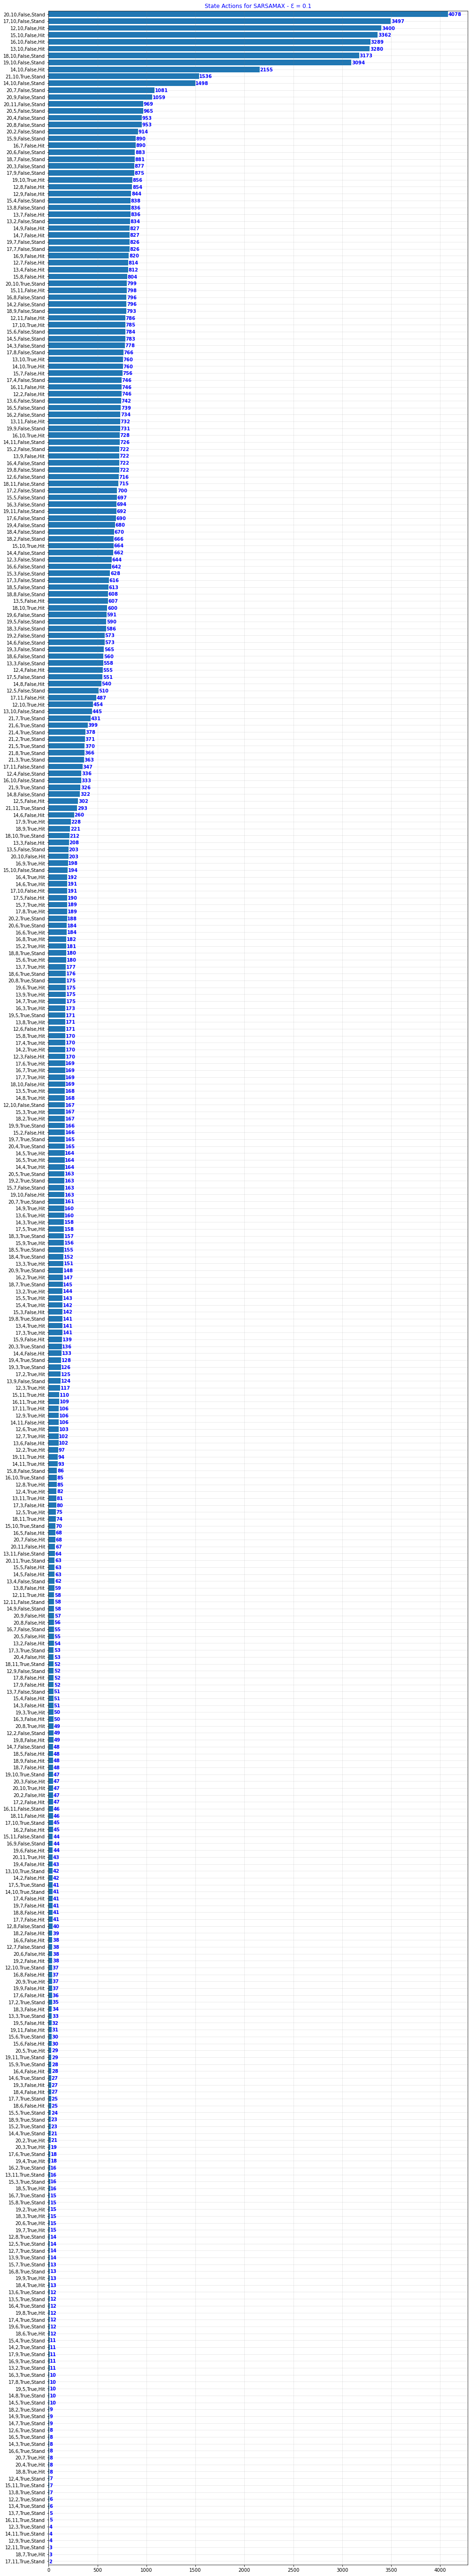

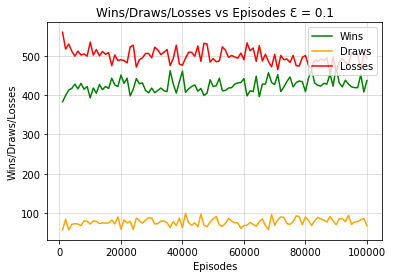


Average Wins: 427

Average Draws: 80

Average Losses: 492

Dealer Advantage: 0.07072905331882481


SarsaMax: Ɛ = 1/k

Episode:  1000  Player Wins: 395  Dealer Wins:  547  Draws:  58  Reward:  -152
Episode:  2000  Player Wins: 418  Dealer Wins:  501  Draws:  81  Reward:  -83
Episode:  3000  Player Wins: 420  Dealer Wins:  499  Draws:  81  Reward:  -79
Episode:  4000  Player Wins: 400  Dealer Wins:  526  Draws:  74  Reward:  -126
Episode:  5000  Player Wins: 428  Dealer Wins:  504  Draws:  68  Reward:  -76
Episode:  6000  Player Wins: 401  Dealer Wins:  515  Draws:  84  Reward:  -114
Episode:  7000  Player Wins: 401  Dealer Wins:  527  Draws:  72  Reward:  -126
Episode:  8000  Player Wins: 416  Dealer Wins:  516  Draws:  68  Reward:  -100
Episode:  9000  Player Wins: 400  Dealer Wins:  501  Draws:  99  Reward:  -101
Episode:  10000  Player Wins: 415  Dealer Wins:  488  Draws:  97  Reward:  -73
Episode:  11000  Player Wins: 441  Dealer Wins:  489  Draws:  70  Reward:  -48
Episode:  12000

,2,3,4,5,6,7,8,9,10,A
20,H,S,H,S,H,H,S,S,S,S
19,H,S,H,H,S,H,S,S,S,S
18,H,S,H,S,H,H,H,H,S,S
17,H,H,H,S,S,S,H,H,H,S
16,H,H,H,H,S,H,H,H,H,H
15,H,H,H,H,H,H,H,H,H,H
14,H,H,H,H,H,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,H,H,H,H,H,H,H



BlackJack Strategy Table when player is using an Ace as 11


,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,S
18,S,H,S,S,S,S,S,S,S,H
17,S,S,S,S,S,S,S,S,H,S
16,S,H,H,S,S,S,S,H,S,H
15,S,S,S,S,S,H,H,H,H,H
14,S,H,S,H,H,S,H,H,H,H
13,S,S,H,H,S,H,S,H,H,H
12,S,S,S,H,S,H,H,H,H,S



No of unique states:  356 



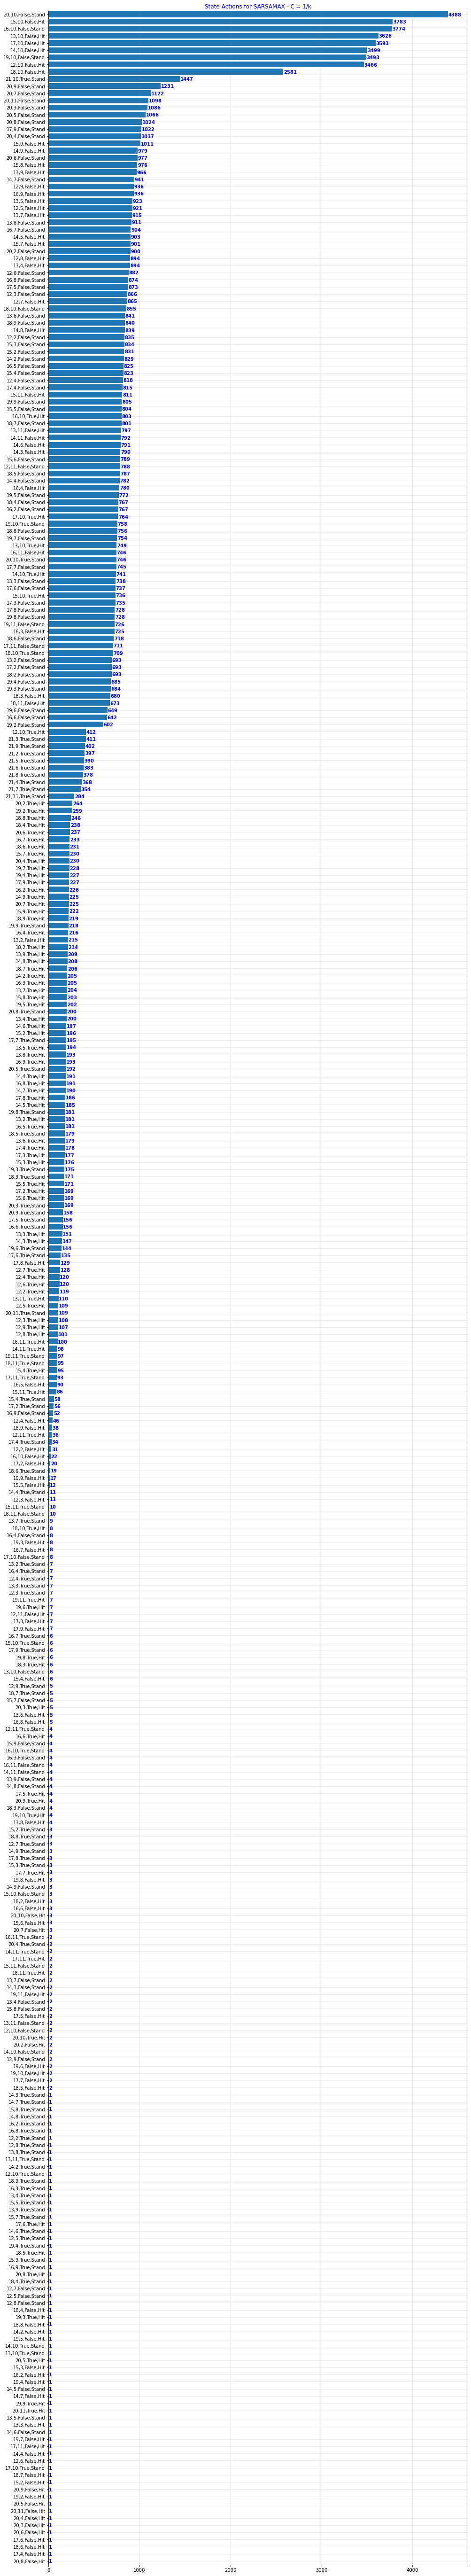

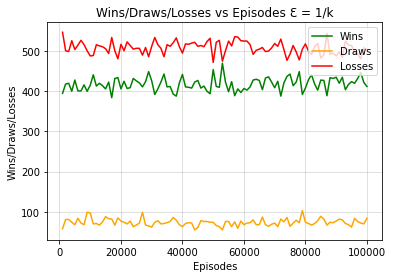


Average Wins: 423

Average Draws: 74

Average Losses: 501

Dealer Advantage: 0.08441558441558442


SarsaMax: Ɛ = e^(-k/1000)  

Episode:  1000  Player Wins: 381  Dealer Wins:  566  Draws:  53  Reward:  -185
Episode:  2000  Player Wins: 402  Dealer Wins:  543  Draws:  55  Reward:  -141
Episode:  3000  Player Wins: 401  Dealer Wins:  532  Draws:  67  Reward:  -131
Episode:  4000  Player Wins: 430  Dealer Wins:  494  Draws:  76  Reward:  -64
Episode:  5000  Player Wins: 425  Dealer Wins:  495  Draws:  80  Reward:  -70
Episode:  6000  Player Wins: 422  Dealer Wins:  504  Draws:  74  Reward:  -82
Episode:  7000  Player Wins: 399  Dealer Wins:  537  Draws:  64  Reward:  -138
Episode:  8000  Player Wins: 419  Dealer Wins:  508  Draws:  73  Reward:  -89
Episode:  9000  Player Wins: 433  Dealer Wins:  509  Draws:  58  Reward:  -76
Episode:  10000  Player Wins: 441  Dealer Wins:  487  Draws:  72  Reward:  -46
Episode:  11000  Player Wins: 446  Dealer Wins:  488  Draws:  66  Reward:  -42
Episode

,2,3,4,5,6,7,8,9,10,A
20,H,H,S,H,H,H,H,S,S,S
19,S,H,S,H,S,S,S,H,S,H
18,H,H,H,H,S,S,H,H,H,H
17,H,H,H,H,H,H,H,H,H,H
16,H,H,H,H,H,H,H,H,H,H
15,H,H,H,H,H,H,H,H,H,H
14,H,H,H,H,H,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,H,H,H,H,H,H,H



BlackJack Strategy Table when player is using an Ace as 11


,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,S
18,S,S,S,S,S,S,S,S,S,S
17,S,S,S,S,S,S,S,S,H,S
16,H,S,H,S,S,S,H,S,H,H
15,S,S,S,S,S,H,H,H,H,H
14,S,S,S,S,S,S,H,H,H,H
13,H,H,S,H,S,H,H,H,H,H
12,S,S,S,S,S,H,H,S,H,H



No of unique states:  359 



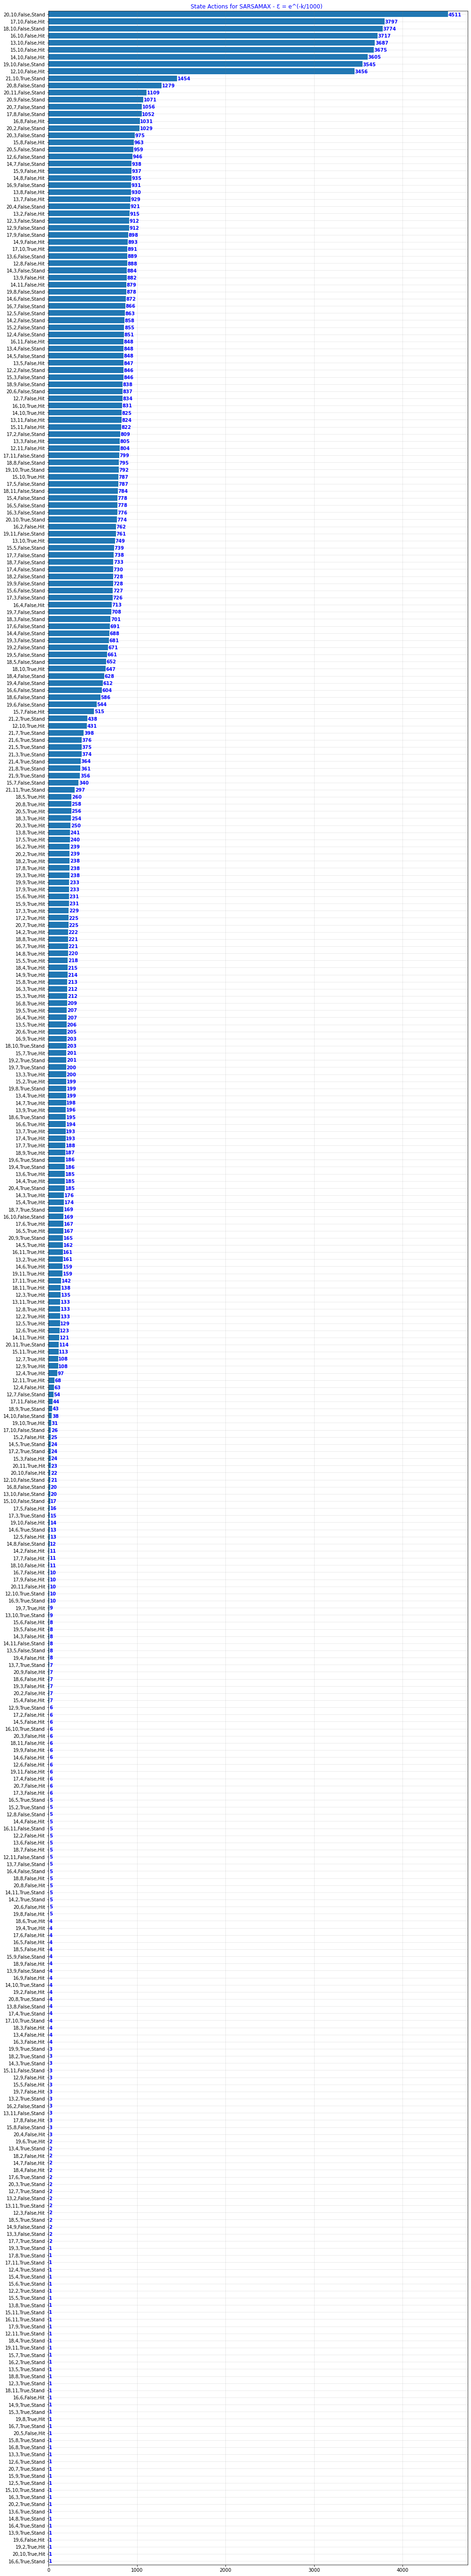

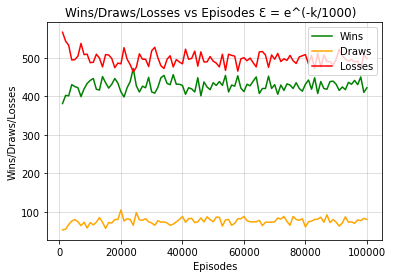


Average Wins: 427

Average Draws: 75

Average Losses: 496

Dealer Advantage: 0.07475622968580715


SarsaMax:  Ɛ = e^(-k/10000)

Episode:  1000  Player Wins: 387  Dealer Wins:  569  Draws:  44  Reward:  -182
Episode:  2000  Player Wins: 346  Dealer Wins:  607  Draws:  47  Reward:  -261
Episode:  3000  Player Wins: 375  Dealer Wins:  580  Draws:  45  Reward:  -205
Episode:  4000  Player Wins: 336  Dealer Wins:  607  Draws:  57  Reward:  -271
Episode:  5000  Player Wins: 362  Dealer Wins:  582  Draws:  56  Reward:  -220
Episode:  6000  Player Wins: 364  Dealer Wins:  584  Draws:  52  Reward:  -220
Episode:  7000  Player Wins: 363  Dealer Wins:  584  Draws:  53  Reward:  -221
Episode:  8000  Player Wins: 398  Dealer Wins:  541  Draws:  61  Reward:  -143
Episode:  9000  Player Wins: 395  Dealer Wins:  548  Draws:  57  Reward:  -153
Episode:  10000  Player Wins: 413  Dealer Wins:  514  Draws:  73  Reward:  -101
Episode:  11000  Player Wins: 419  Dealer Wins:  509  Draws:  72  Reward:  -90
E

,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,H,S,S,S,S,S
18,H,H,S,H,H,S,S,H,H,H
17,H,H,S,H,H,H,H,H,H,H
16,H,H,H,H,H,H,H,H,H,H
15,H,H,H,H,H,H,H,H,H,H
14,H,H,H,H,H,H,H,H,H,H
13,H,H,H,H,H,H,H,H,H,H
12,H,H,H,H,H,H,H,H,H,H



BlackJack Strategy Table when player is using an Ace as 11


,2,3,4,5,6,7,8,9,10,A
20,S,S,S,S,S,S,S,S,S,S
19,S,S,S,S,S,S,S,S,S,S
18,S,S,S,S,S,S,S,S,S,S
17,S,S,S,S,S,S,S,S,S,S
16,S,S,S,S,S,H,H,S,H,H
15,S,H,S,S,S,H,H,S,H,S
14,S,S,S,S,S,H,H,H,H,H
13,S,S,S,S,S,H,H,H,H,H
12,H,S,S,H,S,H,H,H,H,H



No of unique states:  370 



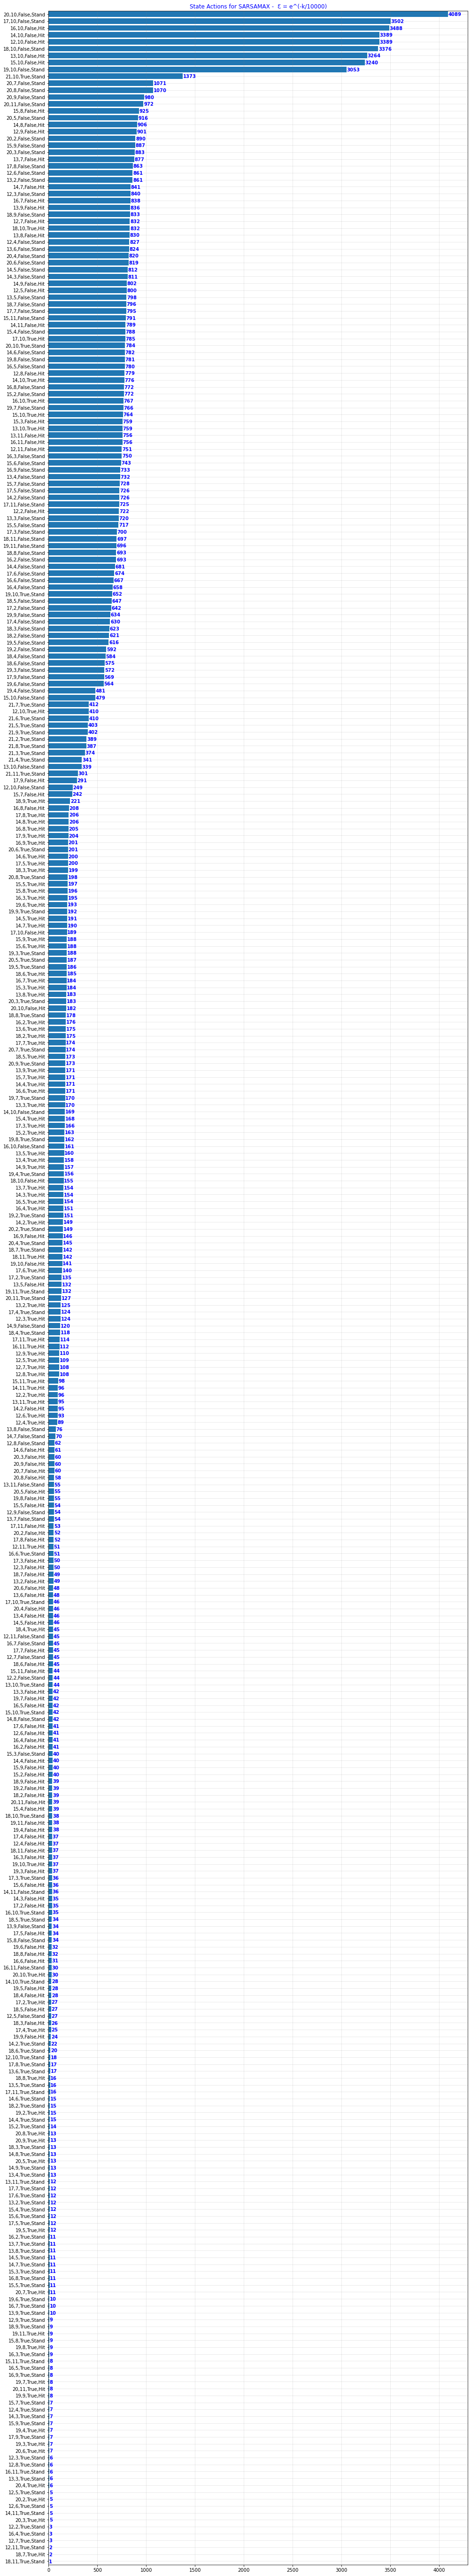

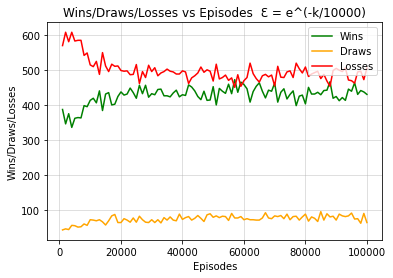


Average Wins: 433

Average Draws: 80

Average Losses: 486

Dealer Advantage: 0.05767138193688792


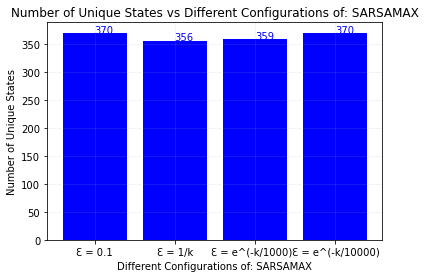

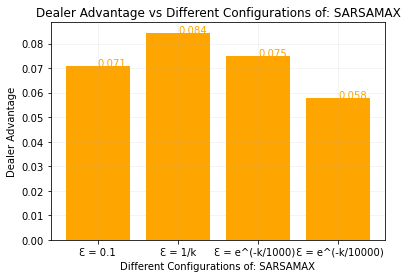

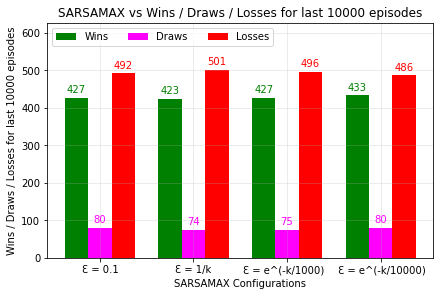


Choose an Algorithm:
1. Monte Carlo
2. SARSA
3. SARSAMAX (Q-Learning)
4. Quit
4
Have a good one! :)


In [27]:
Menu()